In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.applications import VGG19,ResNet152
import cv2
import os
import random
import tensorflow as tf
import torch
from keras.applications import InceptionResNetV2
import numpy as np 
import pandas as pd 
from keras import regularizers
from keras.layers import BatchNormalization

In [8]:
labels = ['bellflower','daisy','dandelion','tulip','sunflower','rose','lotus','iris']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

data = get_data("D:/STUDY/CODE/ML/PredFlower/Data/flowers")

OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.6.0) D:\a\ope

C:\Users\Nguyen Duc Thinh\AppData\Local\Temp\ipykernel_22796\1365412022.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


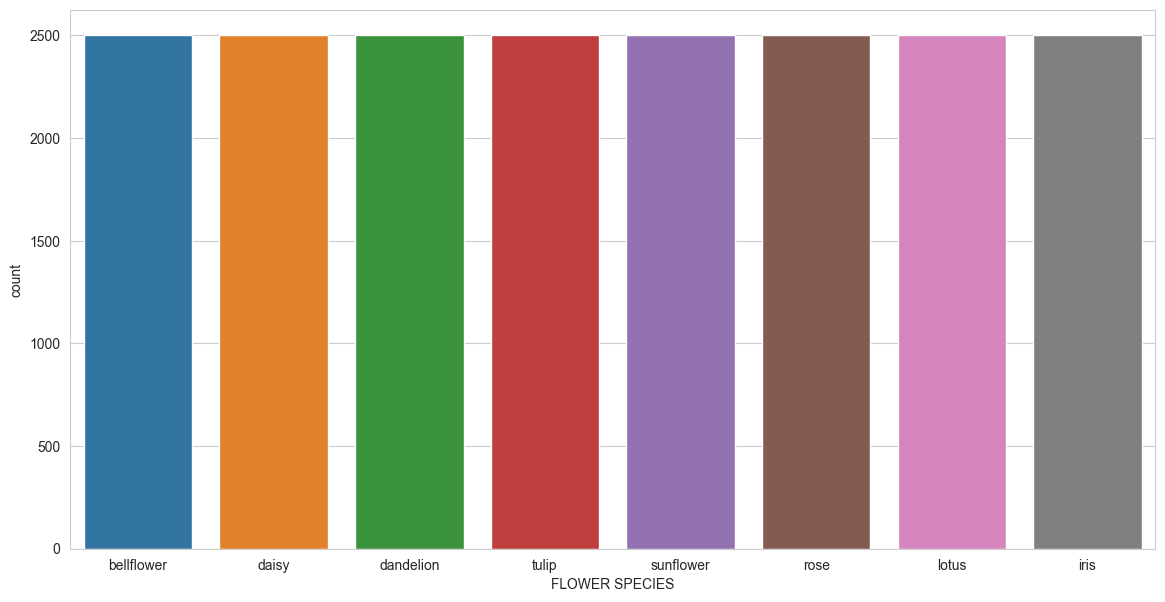

In [9]:
l = []
for i in data:
    l.append(labels[i[1]])
plt.figure(figsize=(14,7))
sns.set_style('whitegrid')
sns.countplot(x=l)
plt.xlabel('FLOWER SPECIES')
plt.show()

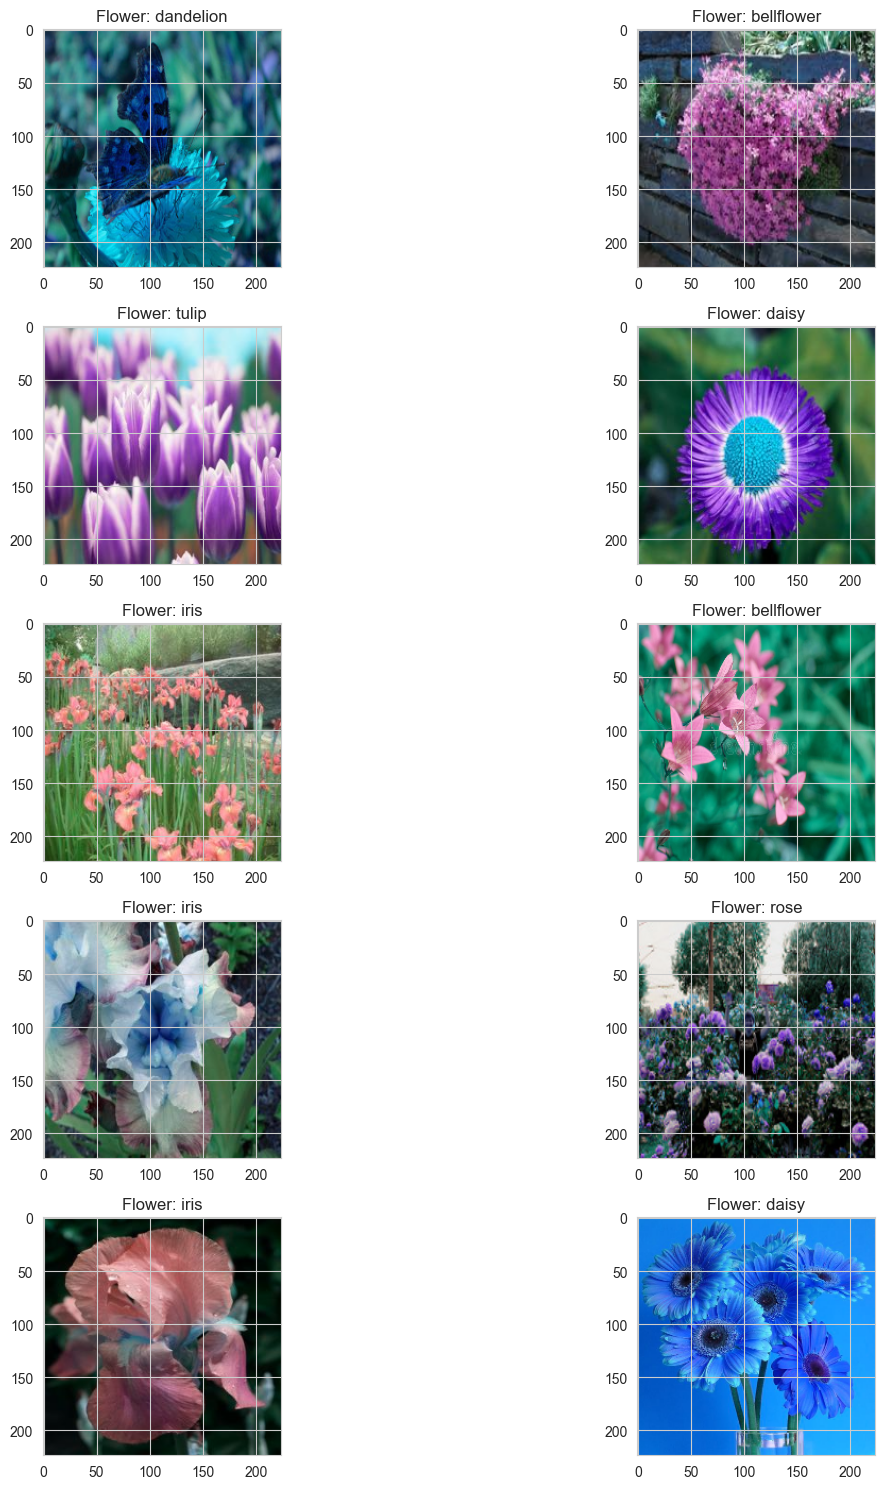

In [10]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(data))
        ax[i,j].imshow(data[l][0])
        ax[i,j].set_title('Flower: '+labels[data[l][1]])
        
plt.tight_layout()

In [11]:
x = []
y = []

for feature, label in data:
    x.append(feature)
    y.append(label)

In [12]:
# Normalize the data
x = np.array(x) / 255

MemoryError: Unable to allocate 22.4 GiB for an array with shape (20000, 224, 224, 3) and data type float64

In [ ]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's 
x = x.reshape(-1, img_size, img_size, 3)
y = np.array(y)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x , y , test_size = 0.2 , stratify = y , random_state = 42)
print("Shape of x_train")
print(x_train.shape)
print("\nShape of x_test")
print(x_test.shape)

Shape of x_train
(15888, 112, 112, 3)

Shape of x_test
(3972, 112, 112, 3)


In [ ]:
del x,y,data

In [ ]:
y.shape

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [ ]:
with strategy.scope():
    pre_trained_model = VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:19]:
        layer.trainable = False
        
    model = Sequential([
    pre_trained_model,
    MaxPool2D((2,2) , strides = 2),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(8, activation='softmax')
])
    model.add(BatchNormalization())
    model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 512)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                        

In [ ]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(x_train,y_train, batch_size = 64 , epochs = 20 , validation_data = (x_test, y_test),callbacks = [learning_rate_reduction])

Epoch 1/20
249/249 [==============================] - ETA: 0s - loss: 9.7201 - accuracy: 0.1235

KeyboardInterrupt: 

In [ ]:
print("Loss of the model is " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is " , model.evaluate(x_test,y_test)[1]*100 , "%")

NameError: name 'model' is not defined

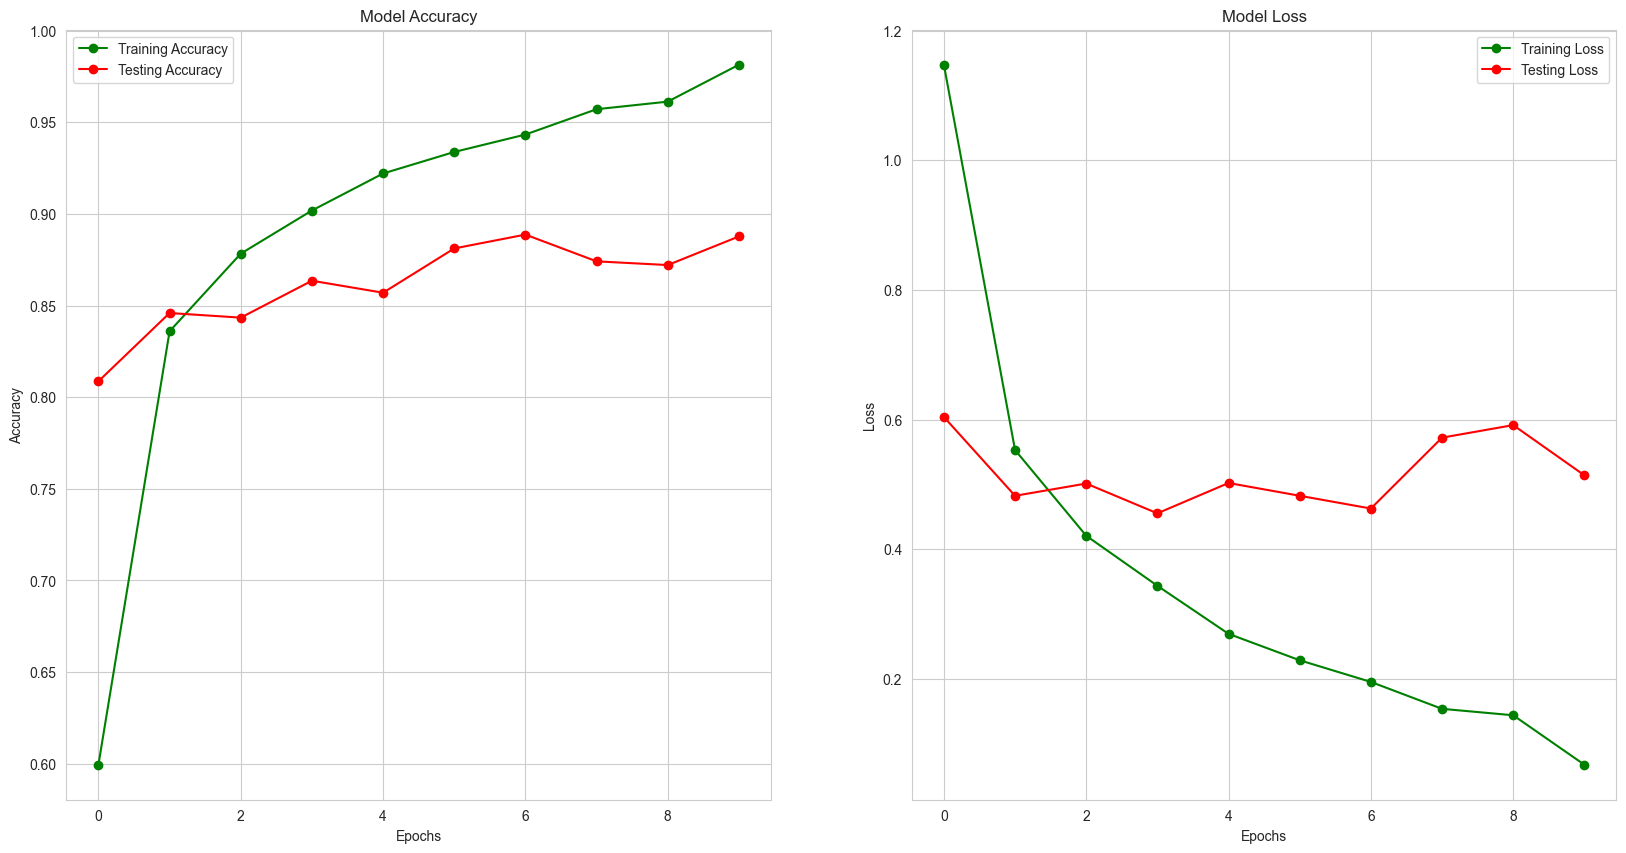

In [ ]:
epochs = [i for i in range(10)]
sns.set_style('whitegrid')
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Model Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
# predict class probabilities for x_test
class_probabilities = model.predict(x_test)
predictions = class_probabilities.argmax(axis=-1)
print(predictions[:8])

63/63 [==============================] - 196s 3s/step
[5 5 1 1 3 6 6 7]


In [ ]:
y_test_inv = label_binarizer.inverse_transform(y_test)

In [ ]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test_inv)):
    if(y_test_inv[i] == predictions[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test_inv)):
    if(y_test_inv[i] != predictions[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

**CORRECTLY CLASSIFIED FLOWER IMAGES**

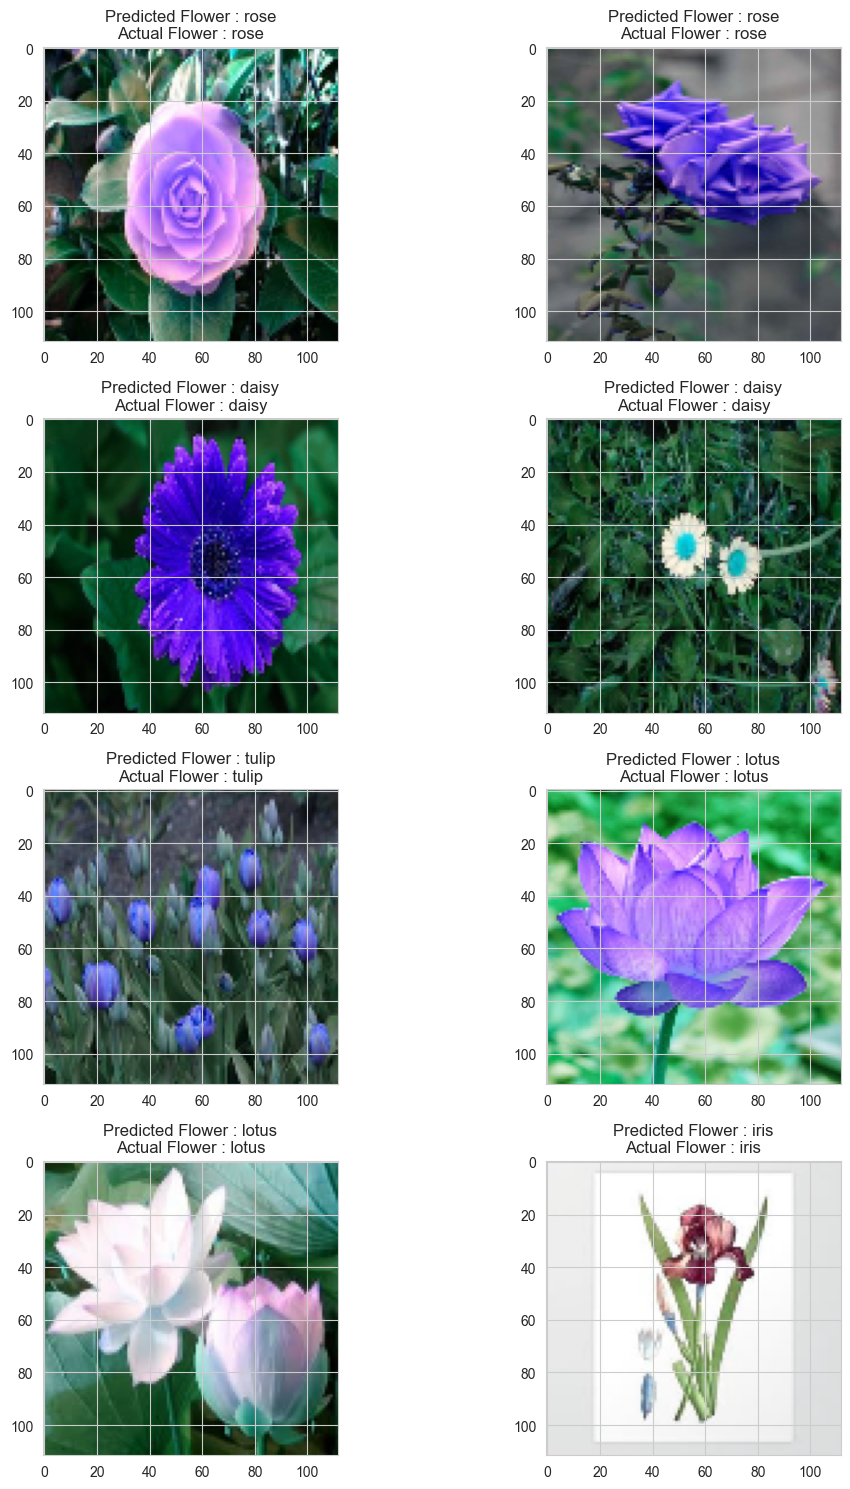

In [ ]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+ labels[predictions[prop_class[count]]] +"\n"+"Actual Flower : "+ labels[y_test_inv[prop_class[count]]])
        plt.tight_layout()
        count+=1

**INCORRECTLY CLASSIFIED FLOWER IMAGES**

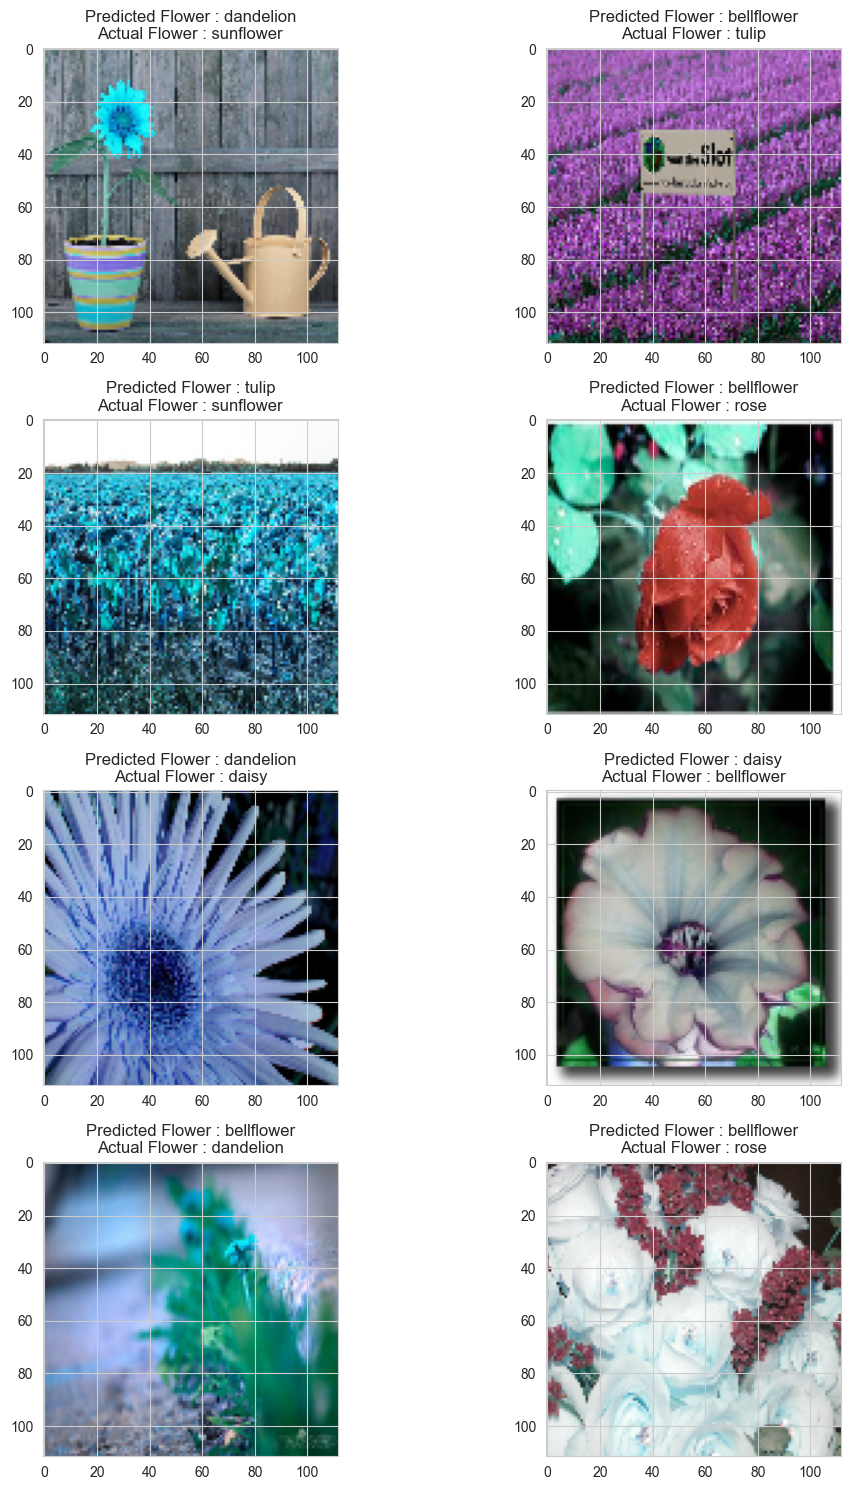

In [ ]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+labels[predictions[mis_class[count]]]+"\n"+"Actual Flower : "+labels[y_test_inv[mis_class[count]]])
        plt.tight_layout()
        count+=1

In [ ]:
cm = confusion_matrix(y_test_inv,predictions)
cm = pd.DataFrame(cm , index = labels , columns = labels)
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = labels , yticklabels = labels )
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

In [ ]:
report = classification_report(y_test_inv, predictions, output_dict=True, target_names = labels)
report_df = pd.DataFrame(report).transpose()
pd.set_option("display.max_rows", None)
report_df.head(134)

report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 5))
plt.title('Classification Report')
plt.xlabel('Labels')
plt.ylabel('Score')
plt.xticks(rotation=0)

plt.show()

precision    recall  f1-score      support
bellflower     0.837037  0.907631  0.870906   249.000000
daisy          0.863830  0.821862  0.842324   247.000000
dandelion      0.884615  0.920000  0.901961   250.000000
tulip          0.869388  0.852000  0.860606   250.000000
sunflower      0.936000  0.936000  0.936000   250.000000
rose           0.866379  0.830579  0.848101   242.000000
lotus          0.925000  0.888000  0.906122   250.000000
iris           0.921260  0.943548  0.932271   248.000000
accuracy       0.887714  0.887714  0.887714     0.887714
macro avg      0.887939  0.887452  0.887286  1986.000000
weighted avg   0.888054  0.887714  0.887475  1986.000000